# Time Series Modeling: Spain Energy Data

## Prepare Notebook

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Notebook Preferences**

In [2]:
#Set Pandas preferenes
pd.options.display.max_rows = 100

#Set style for matplotlib
plt.style.use('ggplot')

#Surpress annoying warnings
warnings.filterwarnings('ignore')

**Read in data**

In [9]:
#Set path to data
path = r'\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\03_Processed_Data'

#Read in training and test data
X_train = pd.read_csv(path + '/2020_0622_Training_Data.csv', index_col=0, parse_dates=['date_time'])
y_train = pd.read_csv(path + '/2020_0622_Training_Labels.csv', index_col=0, parse_dates=['date_time'])
X_test = pd.read_csv(path + '/2020_0622_Test_Data.csv', index_col=0, parse_dates=['date_time'])
y_test = pd.read_csv(path + '/2020_0622_Test_Labels.csv', index_col=0, parse_dates=['date_time'])

#Read in price forecasts data
price_forecasts = pd.read_csv(path + '/2020_0620_Data_Price_Forecasts.csv', index_col=0,parse_dates=['time'])

**Preview Data**

In [10]:
#df.drop_duplicates(inplace=True)
print('Energy data shape:',X_train.shape)
display(X_train.head())
print('\nPrice forecasts shape:',price_forecasts.shape)
display(price_forecasts.head())

Energy data shape: (29810, 16)


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,temp,total load actual
date_time,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,30.814633,25385.0
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,30.852860,24382.0
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,30.108448,22734.0
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,30.091044,21286.0
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,30.192620,20264.0



Price forecasts shape: (35064, 1)


,price_forecast
time,
2015-01-01 00:00:00,50.10
2015-01-01 01:00:00,48.10
2015-01-01 02:00:00,47.33
2015-01-01 03:00:00,42.27
2015-01-01 04:00:00,38.41


# Modeling

### Split Data

In [70]:
#Assign train to X and labels to Y
y = df['price actual']
X= df.drop('price actual', axis =1)

#Split data 85% train and 15% test
cutoff = round(len(X) *.85)
X_train = X[:cutoff]
X_test = X[cutoff:]
y_train= y[:cutoff]
y_test= y[cutoff:]

#Check
print('Training data shape{} Label shape: {}'.format(X_train.shape,y_train.shape))
print('Test data shape{} Label shape: {}'.format(X_test.shape,y_test.shape))

Training data shape(29809, 9) Label shape: (29809,)
Test data shape(5260, 9) Label shape: (5260,)


### Evaluate original price forecast performance

**Prepare price_forecasts data**

In [71]:
#Split forecasts to evaluate predictions on train/test data
price_train = price_forecasts.price_forecast[:cutoff]
price_test = price_forecasts.price_forecast[cutoff:]

#Check label shapes
print('Train label shape{} Test label shape: {}'.format(price_train.shape,price_test.shape))

Train label shape(29809,) Test label shape: (5255,)


**Evaluate fit and performance**

{'MAE': 8.591562440600645, 'MAPE': 0.12350373121825298, 'MSE': 142.8681033453716, 'RMSE': 11.952744594668273}


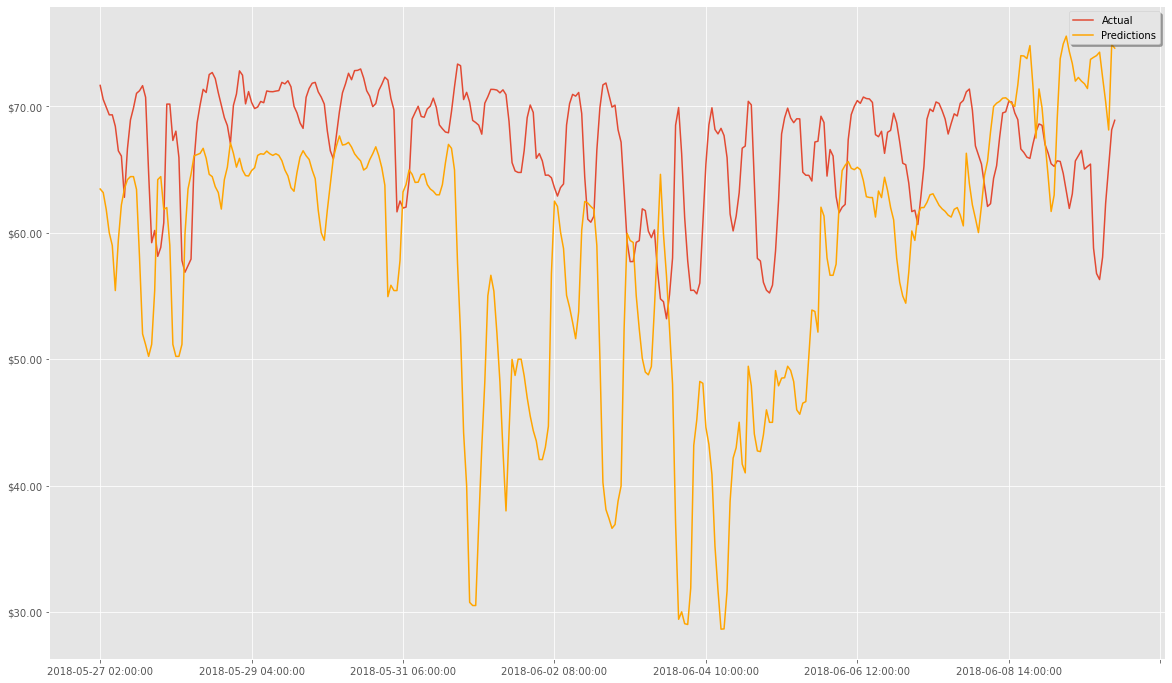

In [72]:
#Read in model_performance to capture metrics
from TimeSeriesStats import model_performance

#Capture predictions
predictions = price_test

#Evaluate price preditions
print(model_performance(predictions, y_test))

#Plot predictions against actual
from TimeseriesPlotter import timeseries_plot

#Create fig
f, ax = plt.subplots(figsize = (20,12))

#Plot original data
timeseries_plot(y_test[:24*14],title='Evaluating Original Price Predictions\n' ,label = 'Actual', ax = ax)

timeseries_plot(predictions[:24*14], color = 'orange', label = 'Predictions', ax = ax, legend = True)

###Set plot aesthetics###
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))

### Build Base Model - Persistence Model Forecast

**Build Persistence Model**

In [73]:
#Build forecast
history = [value for value in y_train]
predictions = []

for i in range(len(y_test)):
    predictions.append(history[-1])
    history.append(y_test[i])

**Evaluate fit and performance**

In [74]:
pd.Series(predictions)

0       72.22
1       71.67
2       70.56
3       69.96
4       69.34
        ...  
5255    77.61
5256    77.02
5257    76.16
5258    74.30
5259    69.89
Length: 5260, dtype: float64

Text(0.5, 1.0, 'Persistence Model Forecast\nRMSE:2.877')

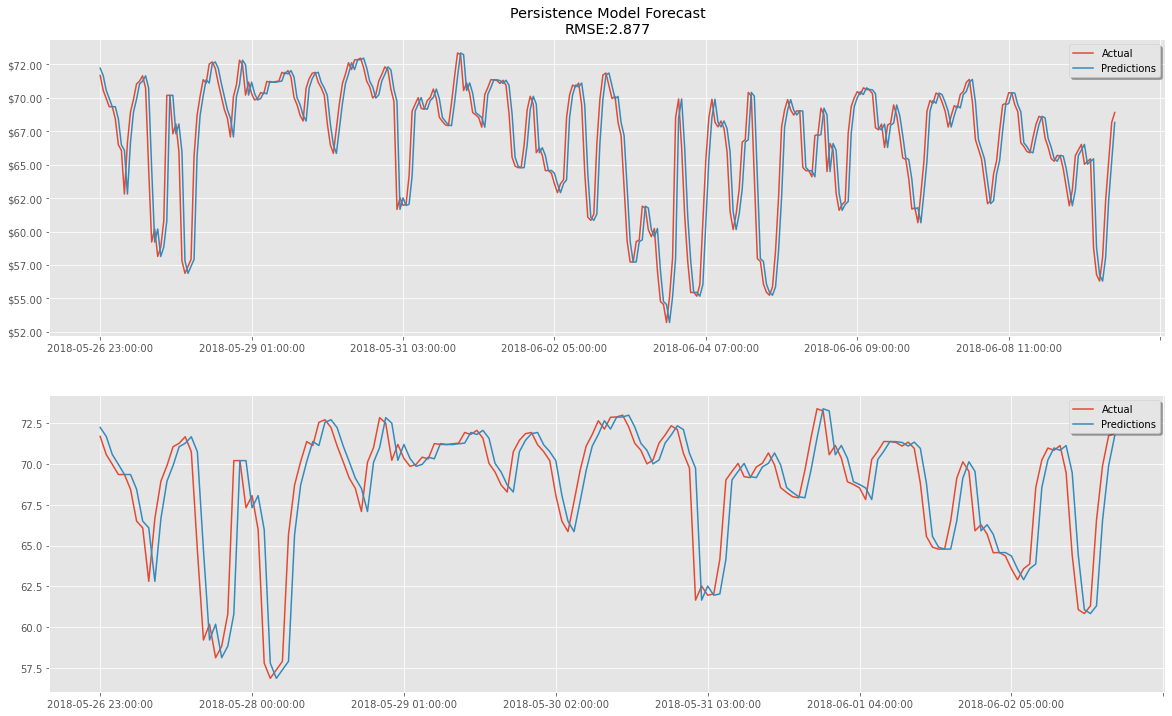

In [75]:
#Create fig
f, ax = plt.subplots(2,1,figsize = (20,12))

#Evaluate base model and store as metrics
metrics= model_performance(predictions,y_test)

#Plot data 2 week zoom
timeseries_plot(y_test[:24*14], ax=ax[0], label = 'Actual')
timeseries_plot(pd.Series(predictions[:24*14]), ax=ax[0], label = 'Predictions', legend=True)

#Plot data 1 week zoom
timeseries_plot(y_test[:24*7], ax=ax[1], label = 'Actual')
timeseries_plot(pd.Series(predictions[:24*7]), ax=ax[1], label = 'Predictions', legend=True)

###Set plot aesthetics###
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[0].set_title('Persistence Model Forecast\nRMSE:{}'.format(round(metrics['RMSE'],3)))

### Build VAR Model

In [78]:
#Read in and init VARMAX
from statsmodels.tsa.api import VAR


In [85]:
model = VARMAX(X_train,order=(1,0))
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
#granger causility tes
result = model.fit(maxiter = 1000,disp=False )

In [80]:
print(result.summary())

                                                                                                                                                    Statespace Model Results                                                                                                                                                    
Dep. Variable:     ['generation fossil gas First Order Differenced', 'generation fossil hard coal First Order Differenced', 'generation hydro pumped storage consumption First Order Differenced', 'price actual First Order Differenced', 'total load actual First Order Differenced']   No. Observations:                29809
Model:                                                                                                                                                                                                                                                                           VAR(1)   Log Likelihood             -963104.540
                                     

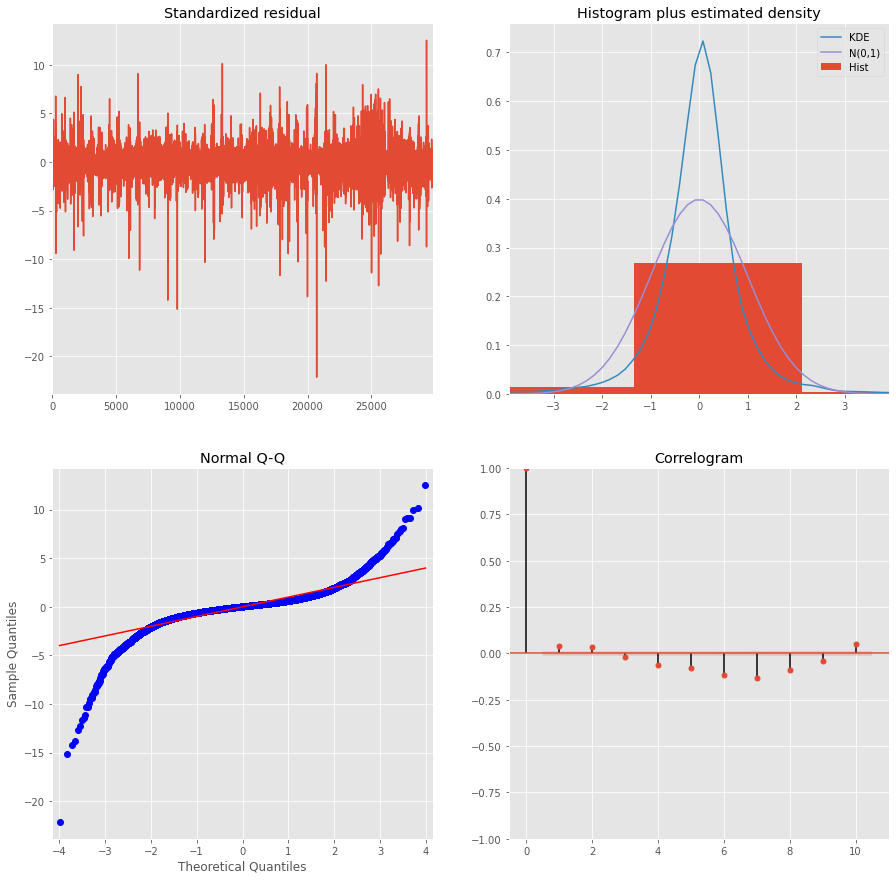

In [83]:
result.plot_diagnostics(figsize = (15,15));


In [ ]:
model.predict(X_test)

### Build LSTM model

**Prepare data**